This is self contained and simplified version of the code.

In [1]:
using Random
using Distributions
using CubicSplines
using Plots
using Interpolations
using JLD2
Random.seed!(1234);

Starting PreProcessing: Settings 

In [2]:
logplot=true
racedistance=10000.0 #in meters
timestep=0.4 # should divide observertimestep
observertimestep=1.0
observernsteps=8080
endtime=8080.0
frontviewdistance=4.0 # Linear Reference distance in front of the runner
minratio=15.0/40.0
maxratio=25.0/40.0
minrho=0.4
maxrho=0.8
posweights=[0.2 0; 2.0 30;  1.5 60;  1.25 120; 1.0 100000]
ldist=0.5
gap=180
waves=[ 2333 500 500 0.0 3.34;
        500  2333 500 (214 +1*gap) 2.92;
        500 500 2334 (440.0+2*gap) 2.5]

trackname="track2"
trackdata=[-500.0 0.0 10.0;
          -400.0 0.0 10.0;
          -300.0 0.0 10.0;
          -200.0 0.0 10.0;
          -100.0 0.0 10.0;
          0.0 0.0 10.0;
          100.0 0.0 10.0;
          1000.0 10.0 10.0;
          2000.0 -2.0 5.0;
          2200.0 -2.0 3.0;
          2300.0 -1.0 3.0;
          2400.0 -1.0 3.0;
          2500.0 -1.0 6.0;
          3000.0 -15.0 10.0;
          4000.0 20.0 2.0;
          5000.0 -7.0 10.0;
          6000.0 9.0 10.0;
          7000.0 -10.0 10.0;
          8000.0 -1.0 7.0;
          9000.0 1.0 10.0;
          10000.0 0.0 10.0;
          10100.0 0.0 10.0;
          10200.0 0.0 10.0];

In [3]:
struct Parameters
    timestep::Float32
    observertimestep::Float32
    observernsteps::Int16
    endtime::Float32
    waves::Matrix{Float32}
    frontviewdistance::Float32
    minratio::Float32
    maxratio::Float32
    minrho::Float32
    maxrho::Float32
    posweights::Matrix{Float32}
    ldist::Float32
    numberofwaves::Int8
    nrunners::Int16
    trackname::String
    trackdata::Matrix{Float32}
    racedistance::Float32
    logplot::Bool
end

In [4]:
numberofwaves=size(waves)[1]
nrunners=Int(sum(waves[:,1:numberofwaves]))
println(">Control Settings: nrunners = ", nrunners)
parameters=Parameters(timestep,observertimestep,observernsteps, endtime,
               waves,frontviewdistance,minratio,maxratio,minrho,maxrho,
               posweights,ldist, numberofwaves, nrunners, trackname,trackdata,
               racedistance,logplot);

>Control Settings: nrunners = 10000


In [5]:
trackname=parameters.trackname;
data=parameters.trackdata;

In [6]:
struct Tracks
    name::String
    x_data::Vector{Float32}
    diff_data::Vector{Float32}
    width_data::Vector{Float32}
    cspline_elev::CubicSplines.CubicSpline{Float32}
    cspline_width::CubicSplines.CubicSpline{Float32}
    foresightarea_data::Vector{Float32}
end

In [7]:
x_data=data[:,1]
diff_data=data[:,2]
width_data=data[:,3]
cspline_elev=CubicSpline(x_data,diff_data)
cspline_width=CubicSpline(x_data,width_data)

roadstart=0.0
roadend=floor(Int,parameters.racedistance)
roadbins= range(roadstart,roadend-1.0,ceil(Int,parameters.racedistance))
foresightarea_data=zeros(size(roadbins)[1]);

In [8]:
for bin in roadbins
    h=parameters.frontviewdistance
    a=bin
    b=a+h
    wa=cspline_width(a)
    wb=cspline_width(b)
    foresightarea_data[floor(Int,bin)+1]=(wa+wb)*h/2.0
end


track=Tracks(trackname,x_data,diff_data,width_data,cspline_elev,cspline_width,foresightarea_data);


In [9]:
function plot_diff_track(track)
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    ys=track.cspline_elev(xs)
    display(plot(xs, ys,title="Elevation (m)",reuse=false))


end

function plot_width_track(track)
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    #fig, ax = plt.subplots(figsize=(6.5, 4))
    #ax.plot(self.x_data,self.diff_data, 'o', label='data')
    ys=track.cspline_width(xs)
    display(plot(xs, ys,reuse=false, title="Width (m)"))

end

function plot_slope_track(track)
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    spline=track.cspline_elev
    slope=zeros(0)
    for x in xs
        append!(slope, 100*CubicSplines.gradient(spline,x,1))
    end
  display(plot(xs, slope,reuse=false,title="Slope (%)"))

end


plot_slope_track (generic function with 1 method)

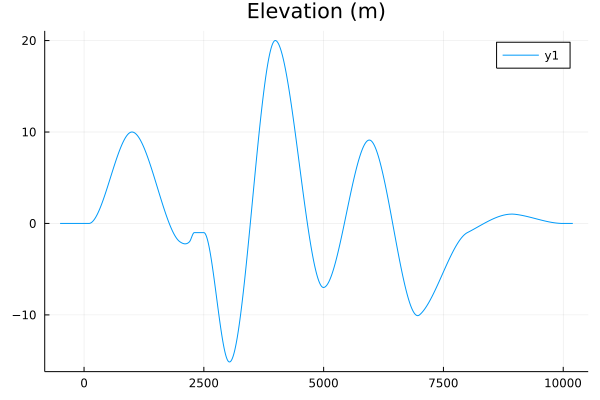

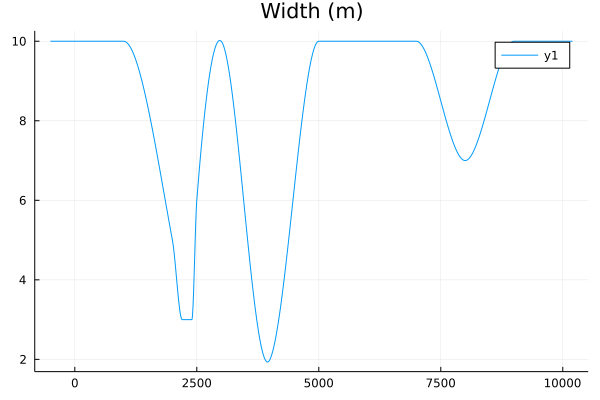

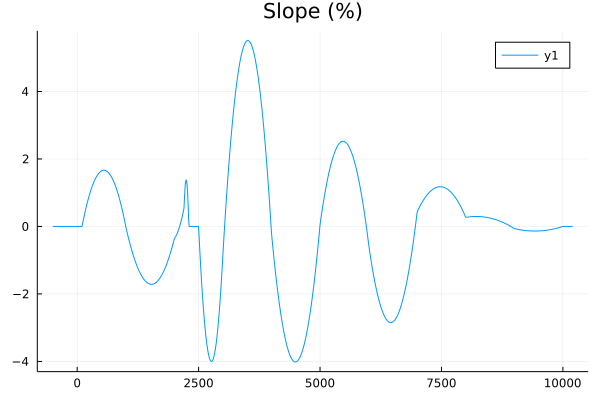

In [10]:
if parameters.logplot==true
    plot_diff_track(track)
    plot_width_track(track)
    plot_slope_track(track)
end

In [11]:
TimeBins=[i for i in 30:100];

In [12]:
ReactionLineTime=0.4

RunnerDist=[15,18,20,17,18,18,31,40,45,72,96,88,109,131,155,192,
            207,270,281,263,326,298,268,240,309,296,346,313,323,347,
            286,325,281,274,291,252 ,285,220,220,207,213,180,172,145,140,
            151,112,145,96,85,85,87,85,73,42,47,27,39,45,31,28,29,24,21,15,21,14,17,14,12,12]

AcumulatedRelativeRunnerDist=cumsum(RunnerDist/sum(RunnerDist));

In [13]:
function inversepseudosigmoid( )
    par=parameters
    ldist=par.ldist
    nrunners=Int(par.nrunners)
    nwaves=par.numberofwaves
    mixwaves=Int.(par.waves[:,1:nwaves])

    println(">Control PreProcessing size(mixwaves) =", size(mixwaves))

    wavedelays=par.waves[:,nwaves+1]
    waveinitspeeds=par.waves[:,nwaves+2]

    partitions=zeros(Float32,size(mixwaves)[1]+1)
    for part in range(1,nwaves)
        partitions[part+1]=partitions[part]+sum(mixwaves[:,part])/nrunners
    end

    println(">Control PreProcessing: partitions ", partitions)
    println(">Control PreProcessing: number of waves",  nwaves)

    waves=zeros(Float32,nrunners)
    wb=1
    we=1

    for wave in range(1, nwaves)
        parts=zeros(Float32,sum(mixwaves[wave, 1 : nwaves]))
        pb=1
        pe=1
        for part in range(1, nwaves)
            size=mixwaves[wave,part]
            println(">Control PreProcessing: sizes of parts of mixwaves:",  size)
            pe+=size
            wavepart=rand(Uniform(partitions[part],partitions[part+1]),size)
            println(">Control PreProcessing: uniform part begin= ", partitions[part], " end= ", partitions[part+1])
            parts[pb:pe-1]=wavepart
            pb=pe
        end
        we+=size(parts)[1]
        println(">Control PreProcessing: uniform wb = ", wb," we-1 = ", we-1)
        #mix parts in each wave
        shuffle!(parts)
        waves[wb:we-1]=parts
        wb=we
    end

    RandDist=waves
    #println(RandDist)
    println(">Control PreProcessing: size(AcumulatedRelativeRunnerDist) = ", size(AcumulatedRelativeRunnerDist))
    println(">Control PreProcessing: size(TimeBins) = ", size(TimeBins))

    AvgTimes=CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,  extrapl=[1, ], extrapr=[1, ])[RandDist]
    println(">Control PreProcessing:: number of runners =",size(AvgTimes))
    #sort!(AvgTimes) # The Fastest are in the first Lines

    InitPositions=zeros(Float32,nrunners)
    WaveDelays=zeros(Float32,nrunners)
    WaveInitSpeeds=zeros(Float32,nrunners)
    SlopeFactors=rand(Uniform(-13.0,-3.0),nrunners)

    # Position along the start line
    NinWaves=Int.(zeros(Float32,nwaves))
    for wave in range(1,nwaves)
        NinWaves[wave]=sum(mixwaves[wave, 1: nwaves])
    end


    itemcount=0
    for (nwave,nrunners) in enumerate(NinWaves)
        linecounter=0
        for i in range(1,nrunners)
            # To avoid truncations due to the cubic spline
            auxwidthcontrl=Int(floor(track.cspline_width(-linecounter*ldist)+0.5))

            if (i+1)%auxwidthcontrl==0
                linecounter+=1
            end
            InitPositions[i+itemcount]=-linecounter*ldist#+0.30*np.random.random_sample()-0.15
            WaveDelays[i+itemcount]=wavedelays[nwave]+linecounter*ReactionLineTime
            WaveInitSpeeds[i+itemcount]=waveinitspeeds[nwave]
        end
        itemcount+=nrunners
    end

    return AvgTimes, RandDist, NinWaves,InitPositions, WaveDelays,WaveInitSpeeds,SlopeFactors
end


inversepseudosigmoid (generic function with 1 method)

In [14]:
AvgTimes, RandDist,NinWaves,InitPositions, WaveDelays,WaveInitSpeeds, SlopeFactors= inversepseudosigmoid();


>Control PreProcessing size(mixwaves) =(3, 3)
>Control PreProcessing: partitions Float32[0.0, 0.3333, 0.6666, 1.0]
>Control PreProcessing: number of waves3
>Control PreProcessing: sizes of parts of mixwaves:2333
>Control PreProcessing: uniform part begin= 0.0 end= 0.3333
>Control PreProcessing: sizes of parts of mixwaves:500
>Control PreProcessing: uniform part begin= 0.3333 end= 0.6666
>Control PreProcessing: sizes of parts of mixwaves:500
>Control PreProcessing: uniform part begin= 0.6666 end= 1.0
>Control PreProcessing: uniform wb = 1 we-1 = 3333
>Control PreProcessing: sizes of parts of mixwaves:500
>Control PreProcessing: uniform part begin= 0.0 end= 0.3333
>Control PreProcessing: sizes of parts of mixwaves:2333
>Control PreProcessing: uniform part begin= 0.3333 end= 0.6666
>Control PreProcessing: sizes of parts of mixwaves:500
>Control PreProcessing: uniform part begin= 0.6666 end= 1.0
>Control PreProcessing: uniform wb = 3334 we-1 = 6666
>Control PreProcessing: sizes of parts of

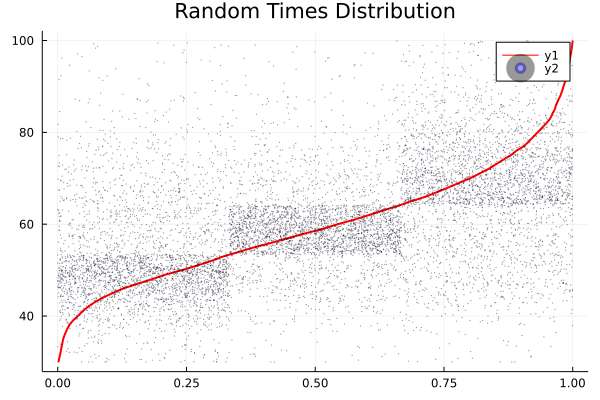

In [15]:
if parameters.logplot==true
    plot(AcumulatedRelativeRunnerDist,
         CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,
                     extrapl=[1, ], extrapr=[1, ])[AcumulatedRelativeRunnerDist],
         linecolor = :red,lw=2)
    plot!(RandDist,sort(AvgTimes),seriestype = :scatter,
          title="Random Times Distribution",
          markersize=0.3,
          markeralpha = 0.4,
          markercolor = :blue )
end

In [16]:
nrunners=parameters.nrunners;

In [17]:
struct Frunner
    time::Float32
    wavedelay::Float32
    waveinitspeed::Float32
    initposition::Float32
    slopefactor::Float32

    avgspeed::Float32
    pos::Vector{Float32}
    vels::Vector{Float32}
    rhos::Vector{Float32}

end

In [18]:
avgspeed(time)=(10000.0/(time*60.0));

In [19]:
function pos(initposition)
    aux=zeros(parameters.observernsteps)
    aux[1]=initposition
    return aux
end

pos (generic function with 1 method)

In [20]:
vels=zeros(parameters.observernsteps)
rhos=zeros(parameters.observernsteps);

In [21]:
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor)=
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor,
        avgspeed(time),pos(initposition),vels,rhos);

In [22]:
mutable struct Runners
    group::Vector{Main.Frunner}
    nrunners::Int16

    pos::Matrix{Float32} 
    vels::Matrix{Float32}
    rhos::Matrix{Float32}

    wavedelays::Vector{Float32}
    waveinitspeeds::Vector{Float32}
    avgspeeds::Vector{Float32}
    slopefactors::Vector{Float32}

end

In [23]:
nnrunners(group)=size(group)[1]
positions(group)=reduce(hcat,[runner.pos for runner in group])' # ' = transpose
velocities(group)=reduce(hcat,[runner.vels for runner in group])'
rhosall(group)=reduce(hcat,[runner.rhos for runner in group])'
wavedelays(group)=[runner.wavedelay for runner in group]
waveinitspeeds(group)=[runner.waveinitspeed for runner in group]
avgspeeds(group)=[runner.avgspeed for runner in group]
slopefactors(group)=[runner.slopefactor for runner in group]

slopefactors (generic function with 1 method)

In [24]:
Runners(group)=Runners(group,
                       nnrunners(group),
                       positions(group),
                       velocities(group),
                       rhosall(group),
                       wavedelays(group),
                       waveinitspeeds(group),
                       avgspeeds(group),
                       slopefactors(group))

Runners

In [25]:
function RhoVL(R::Vector{Float32},VL::Vector{Float32},X::Vector{Float32},V::Vector{Float32},
               allrunners::Main.Runners,
               par::Main.Parameters,
               track::Main.Tracks,training::Bool)
    nrunners=allrunners.nrunners
    minrho=par.minrho
    maxrho=par.maxrho
    minratio=par.minratio
    maxratio=par.maxratio
    racedistance=par.racedistance
    fvdist=par.frontviewdistance
    # sorted indexes of  the runners
    sortedargs=sortperm(X)
    # rho definition (density container)
    #For VL calculation. average of the  slowest in front of the runner
    foresightarea=zeros(Float32,nrunners)

    # First step: counting the number of runner in the frontview  area
     for (arg_idx, arg) in enumerate(sortedargs)
        if X[arg]< 0.0 continue end #start counting only after crossing the starting line
        if X[arg] > racedistance - fvdist continue end #stop near the crossing the finish line
        foresightarea[arg]=track.foresightarea_data[ceil(Int,X[arg])+1]
        #minn rf is the minimum number of runners in the foresight that impacts the runners speed

        minn=floor(Int, minratio*foresightarea[arg]) #min number of  runners for impact area
        maxn=floor(Int, maxratio*foresightarea[arg]) #min number of  runners for impact are
        #println(minn," ",maxn)
        # continue conditions
        if minn<3 continue end #At least 3 runners in the impact area
        if arg_idx+minn>length(sortedargs) continue end
        if X[sortedargs[arg_idx+minn]]-X[arg]>= fvdist continue end

        rhocounter=1.0
        argsofguysinfront=sortedargs[arg_idx+1:min(arg_idx+maxn,nrunners)]
         for arg_i in argsofguysinfront
            if X[arg_i]-X[arg]>fvdist continue
            else rhocounter+=1.0
            end
        end

        if (rhocounter/foresightarea[arg])>maxratio
            R[arg]=maxrho
            #println(rho[arg])
        elseif ((rhocounter/foresightarea[arg]<=maxratio)
                && (rhocounter/foresightarea[arg]>=minratio))
            D_A=rhocounter/foresightarea[arg]
            R[arg]=(minrho*(D_A-maxratio)-maxrho*(D_A-minratio))/(minratio-maxratio)
            #println(rho[arg])
        end


        lngth=floor(Int,minn/2) #
        #if lngth <2 continue end
        sortedspeeds=sort(V[argsofguysinfront])
        slowersspeeds=sortedspeeds[1:lngth]
        slowersavgspeed=sum(slowersspeeds)/length(slowersspeeds)
        VL[arg]=min(slowersavgspeed,V[arg])
        ############################################################################
    end
    return R,VL
end

# Index r for runner
# Index i for time stepping

# Velocity function dx/dt=F(...)
function F(t::Float32,X::Vector{Float32},V::Vector{Float32},
           allrunners::Main.Runners,
           par::Main.Parameters,
           track::Main.Tracks,training::Bool)
    ## Some alias to simplify
    spline=track.cspline_elev
    nrunners=allrunners.nrunners
    VL=zeros(Float32,nrunners)
    racedistance=par.racedistance
    epsm=100
    R=zeros(Float32,nrunners)

    if training==true
        # Race for timing reports
         for r in 1:nrunners
            # Stop epsm=100m after the finishing line
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            else
                V[r]=(allrunners.avgspeeds[r] + CubicSplines.gradient(spline,X[r],1)*allrunners.slopefactors[r])
            end
        end
    elseif training==false

        R, VL = RhoVL(R,VL,X,V,allrunners,par,track,training)

         for r in 1:nrunners
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            elseif X[r]<0 # This Condition can be improved! (wave propagation in lanes)
                V[r]=min(allrunners.waveinitspeeds[r],allrunners.avgspeeds[r])
            else
                rspeed=(allrunners.avgspeeds[r]+CubicSplines.gradient(spline,X[r],1)*allrunners.slopefactors[r])
                V[r]=(1.0-R[r])*rspeed+R[r]*VL[r]
            end
        end

    end
    return V, R
end



function rk2(allrunners::Main.Runners,
             parameters::Main.Parameters,
             track::Main.Tracks,training::Bool)
    println(">Control OdeSystemSolvers: Entering rk2_solver")

    nrunners=allrunners.nrunners
    obsnsteps=parameters.observernsteps
    obststep=parameters.observertimestep
    dt=parameters.timestep
    nsteps=ceil(Int,parameters.endtime/dt)
    println(">Control OdeSystemSolvers: total number of time steps = ", nsteps)
    avgspeeds=allrunners.avgspeeds
    slopefactors=allrunners.slopefactors

    println(">Control OdeSystemSolvers: number of runners = ", nrunners)
    # Container for the solutions
    times=zeros(Float32,obsnsteps)

    # Internal Copy of allrunners.positions
    positions=allrunners.pos
    println(">control OdeSystemSolvers: size(positions)= ", size(positions))
    println(">control OdeSystemSolvers: initial positions= ", positions[nrunners-10:nrunners,1])

    #println(typeof(positions))
    velocities=zeros(Float32,nrunners,obsnsteps)
    rhos=zeros(Float32,nrunners,obsnsteps)

    X1=positions[:,1] #rk Updated positions
    X0=positions[:,1] #rk old positions
    V=velocities[:,1] # useless since it is 0

    K1=zeros(Float32,nrunners)
    K2=zeros(Float32,nrunners)
    R =zeros(Float32,nrunners)
    #k3=zeros(nrunners)
    #k4=zeros(nrunners)
    j=0
    for i in 0:(nsteps-1)
        t=dt*i
        V, R = F(t,X0, V, allrunners,parameters,track,training) #update velocities
        K1=dt .* V
        V, R = F(t+dt, X0 .+ K1, V,  allrunners,parameters,track,training) #update velocities
        K2=dt .* V
        X1=X0 .+ 0.5 .* (K1 .+ K2) # update positions

        ## Containers for Observer
        if ((i+1)*dt>=(obststep*j) && i*dt<=(obststep*j))
            delta=(j*obststep-i*dt)/dt
            beta=1.0-delta
            times[j+1]=obststep*(j+1)
            ## interpolations
            positions[:,j+1]= beta .* X0 .+ delta .*X1
            velocities[:,j+1]=V #beta .* velocities[:,j] .+delta.* V
            rhos[:,j+1]=R #beta .* rhos[:,j] .+ delta .* R
            if (j+1 == obsnsteps) break end
            j+=1
        end
        X0[:] .= X1[:]
    end

    return times, positions,velocities, rhos

end

rk2 (generic function with 1 method)

In [26]:
solver=rk2

rk2 (generic function with 1 method)

In [27]:
function race()
    println(">control Race: model")
    runnerslist=Array{Frunner,1}(undef, nrunners)
    for i in 1:nrunners
        runnerslist[i]=Frunner(AvgTimes[i],WaveDelays[i],WaveInitSpeeds[i],InitPositions[i],SlopeFactors[i])
    end
    allrunners=Runners(runnerslist)
    println(">Control Race: dump(allrunners)")
    dump(allrunners)
    println(">control Race: sizes(allrunners.group)= ", size(allrunners.group))
    println(">control Race: sizes(allrunners.pos)= ", size(allrunners.pos))
    println(">control Race: sizes(allrunners.vels)= ", size(allrunners.vels))
    println(">control Race: sizes(allrunners.rhos)= ", size(allrunners.rhos))
    println(">control Race: Pre-Processing done")
    println(">control Race: Starting Race Simulation")

    times, allrunners.pos, allrunners.vels, allrunners.rhos=solver(allrunners,parameters,track,false)
    println(">Control Race: Processing done")

    println(">Control Race: Writing to files with jld2")
    println(">Control Race: NinWaves", NinWaves)
    #save it


    save_object("./jlnb/results/times.jld2", times)
    save_object("./jlnb/results/allrunners.jld2",  allrunners)
    save_object("./jlnb/results/parameters.jld2",parameters)
    save_object("./jlnb/results/track.jld2",track)
    save_object("./jlnb/results/ninwaves.jld2",NinWaves)
end

race (generic function with 1 method)

In [28]:
function training()
    training=true
    println(">control Training Race")
    runnerslist=Array{Frunner,1}(undef, nrunners)
    for i in 1:nrunners
        runnerslist[i]=Frunner(AvgTimes[i],WaveDelays[i],WaveInitSpeeds[i],InitPositions[i],SlopeFactors[i])
    end
    allrunners=Runners(runnerslist)
    println(">Control Race: dump(allrunners)")
    dump(allrunners)
    println(">control Training Race: sizes:")
    println(">control Training Race: sizes(allrunners.group)= ", size(allrunners.group))
    println(">control Training Race: sizes(allrunners.pos)= ", size(allrunners.pos))
    println(">control Training Race: sizes(allrunners.vels)= ", size(allrunners.vels))
    println(">control Training Race: sizes(allrunners.rhos)= ", size(allrunners.rhos))
    println(">control Training Race: Pre-Processing done")
    println(">control Training Race: Starting Race Simulation")

    times, allrunners.pos, allrunners.vels, allrunners.rhos=solver(allrunners,parameters,track,training)
    println(">Control Training Race: Processing done")

    println(">Control Training Race: Writing to files with jld2")
    save_object("./jlnb/training_results/allrunners.jld2",  allrunners)

end

training (generic function with 1 method)

In [ ]:
t=@elapsed begin training() end
println(">Elapsed time=", t)

In [ ]:
t=@elapsed begin race() end
println(">Elapsed time=", t)